128.0


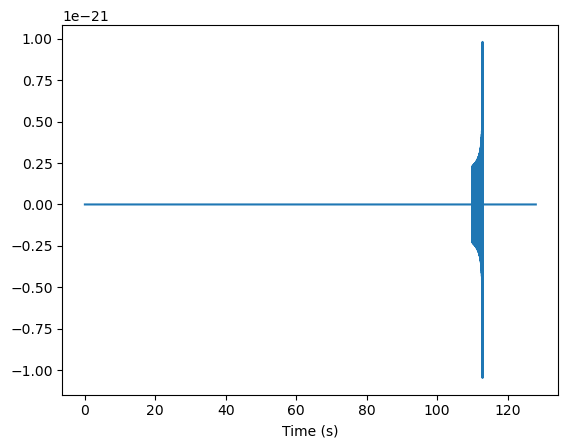

done


In [4]:
import pycbc.noise
import pycbc.psd
import matplotlib.pyplot as plt
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.filter import resample_to_delta_t
from pycbc.frame import write_frame
from pycbc.filter import sigma




fs=4096
flow = 10.0
t=128 #TOTAL TIME OF THE DATA
delta_f = 1.0 / t
psd=pycbc.psd.analytical.aLIGOZeroDetLowPower(t*2048+1,delta_f,flow)
'''
plt.loglog(psd.sample_frequencies,psd)
plt.xlim(30, 1024)
plt.show()
'''

ts=pycbc.noise.gaussian.noise_from_psd(fs*t,1./fs,psd)
ts = resample_to_delta_t(ts, 1.0/fs)
print (ts.duration)
ts.start_time = 0

'''
plt.plot(ts.sample_times, ts)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

'''

m=45 #MASS OF BH
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=m, mass2=m, delta_t=1./fs, f_lower=10)
fs = ts.to_frequencyseries()
hp.resize(len(ts))
hp.start_time = 0


# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time

wavetime = 110                        #WHERE THE SNR PEAK WILL BE (it adds to the GW length) 
aligned = hp.cyclic_time_shift(wavetime)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)


snr=35                         #VALUE OF SNR


# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snr).to_timeseries()
aligned.start_time = ts.start_time




plt.plot(aligned.sample_times, aligned)
plt.xlabel('Time (s)')
plt.show()
dataset= ts + aligned
write_frame('fakedata2.gwf', 'H1:TEST-STRAIN', dataset) #fakedata2.gwf is the name of the returning file
print('done')
